In [12]:
import numpy as np

from scipy import misc
import glob
import imageio
import matplotlib.pyplot as plt
# for image_path in glob.glob("*.png"):
#     image = misc.imread(image_path)
#     print image.shape
#     print image.dtype
    

In [ ]:
!ls depth_map


In [9]:
image = imageio.imread("full_12k_samples_dataset_3_objects/depth_map/aov_image_0016.png")

In [10]:
image.shape

(64, 64, 4)

In [88]:
np.max(image[:,:,0])

124

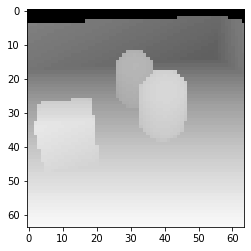

In [89]:
import matplotlib.pyplot as plt

# plt.imshow(image[:,:,0], cmap='gray', vmin=0, vmax=255)
plt.imshow(image[:,:,0], cmap='gray', vmin=0, vmax=127)
plt.show()

In [90]:
np.max(image[:,:,0]) / 127.0

0.9763779527559056

In [91]:
near = 0.8
far = 15

In [92]:
# inverse of perspective projection https://en.wikipedia.org/wiki/Z-buffering#Mathematics
k1 = (far + near) / (far - near)
k2 = (- 2.0 * far * near) / (far - near)

In [93]:
res = k2 / ((image[:,:,0] / np.max(image[:,:,0])) - k1)  

In [94]:
np.histogram(res)

(array([1233,  545,  468,  576,  510,  252,  128,  128,  128,  128]),
 array([ 1.51898734,  2.86708861,  4.21518987,  5.56329114,  6.91139241,
         8.25949367,  9.60759494, 10.9556962 , 12.30379747, 13.65189873,
        15.        ]))

In [95]:
np.max(res)

#6.883468834688346 with 127.0 

14.999999999999993

In [96]:
# use np.max of each image to scale

In [97]:
near = 0.8
far = 15
k1 = (far + near) / (far - near)
k2 = (- 2.0 * far * near) / (far - near)


def get_depth_images():
    depth_np_images = []

    for image_path in glob.glob("depth_map/*.png"):
        image = imageio.imread(image_path)

        divisor = np.max(image[:,:,0]) if np.max(image[:,:,0]) != 0 else 127.0 
        res = k2 / ((image[:,:,0] / divisor) - k1)  

        np.save(image_path.split(".")[0], res)

        depth_np_images.append(res)
        
    return depth_np_images
        
depth_np_images = get_depth_images()

In [ ]:
!ls depth_map


In [ ]:
for item in depth_np_images:
    print(item.shape)
    print(np.max(item))

In [100]:
dim = np.array(depth_np_images).shape

dim

(735, 64, 64)

## Getting Instance segmentation

### Since we only need per object instance segmentation, we are going to compare per object whether depth map and instance segmentation overlap.

### EDIT: this is solved by GameView fix


In [5]:
!ls full_12k_samples_dataset_3_objects

Dataset294cada5-594a-427e-bd62-4bfea69756ba  depth_map	instances  logs  rgb


In [6]:
instance_num = 623
instance_image = imageio.imread(f'full_12k_samples_dataset_3_objects/instances/Instance_{instance_num}.png')

In [49]:
np.max(image)

255

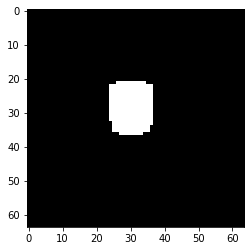

In [70]:
plt.imshow(image[:,:,0], cmap = 'gray', vmin=0, vmax=255)
plt.show()

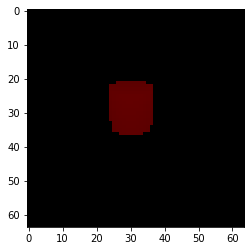

In [62]:
#depth map
depth_image = imageio.imread(f'depth_map/aov_image_0{instance_num-3}.png')
plt.imshow(depth_image, cmap = 'gray', vmin=0, vmax=255)
plt.show()

In [74]:
print(np.min(instance_image[:,:,0]), np.max(instance_image[:,:,0]))
print(np.min(depth_image[:,:,0]), np.max(depth_image[:,:,0]))

0 255
0 99


In [ ]:
## Checking whether depth image and instance segmentation have same pixels filled

In [76]:
pixel_threshold = 10
summed_for_comparison = np.sum((instance_image[:,:,0] > pixel_threshold) == (depth_image[:,:,0] > pixel_threshold))
summed_for_comparison_inverse = np.sum((instance_image[:,:,0] <= pixel_threshold) == (depth_image[:,:,0] <= pixel_threshold))

print(summed_for_comparison_inverse, summed_for_comparison, 64 * 64)

4096 4096 4096


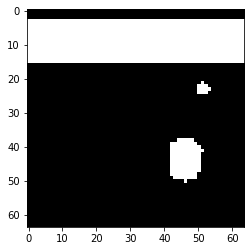

In [16]:
# Thresholding for masks segmentation and collecting 
instance_image = imageio.imread(f'full_12k_samples_dataset_3_objects/instances/Instance_{instance_num -1}.png')

res_instance_image = (instance_image[:,:,0] > 0).astype('bool')
plt.imshow(res_instance_image, cmap = 'gray', vmin=0, vmax=1)
plt.show()

In [20]:
# Thresholding for masks segmentation and collecting 

def get_instance_masks():
    res_instance_masks = []
    for image_path in glob.glob("full_12k_samples_dataset_3_objects/instances/*.png"):
        instance_image = imageio.imread(image_path)
    #     instance_image = imageio.imread(f'images/instances/Instance_{instance_num}.png')
        res_instance_image = (instance_image[:,:,0] > 0).astype('bool')

        np.save(image_path.split(".")[0], res_instance_image)


        res_instance_masks.append(res_instance_image)
        
    return res_instance_masks
    
res_instance_masks = get_instance_masks()

In [22]:
len(res_instance_masks)


130001

In [179]:
len(res_instance_masks)

734

### Depth recording is in advance for 3 frames, make sure depth_image[i - 3] is always included 

## Getting RGB images

In [ ]:
!ls images/rgb

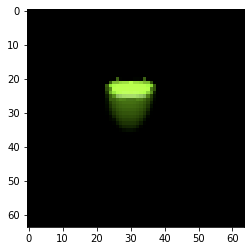

In [112]:
# Thresholding for masks segmentation and collecting 
rgb_image = imageio.imread(f'images/rgb/rgb_{instance_num}.png')

plt.imshow(rgb_image, cmap = 'gray', vmin=0, vmax=255)
plt.show()

In [83]:
## Collecting for 3 foreground objects their values, and 5 values for background objects

### Position, orientation and scale also needs to be collected

#### Scale is always 1, orientation no idea how tf to set this

In [116]:
!ls images/logs/objects_relative_to_cam.json

images/logs/objects_relative_to_cam.json


In [113]:
import json

In [117]:
with open('images/logs/objects_relative_to_cam.json') as f:
  data = json.load(f)

In [121]:
len(data['contentList'])

82

In [124]:
print(np.array(depth_np_images).shape, np.array(res_instance_masks).shape)

(735, 64, 64) (734, 64, 64)


In [126]:
734 / (5 + 3 + 1)

81.55555555555556

In [129]:
data['contentList'][1]['index']

9

In [132]:
print(instance_num, instance_num / (5 + 3 + 1))

623 69.22222222222223


621


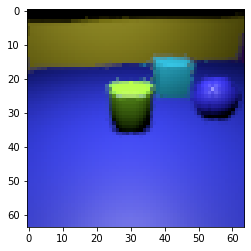

In [147]:
found_base_image = data['contentList'][69]['index']

print(found_base_image)
rgb_image = imageio.imread(f'images/rgb/rgb_{found_base_image + 1}.png')

plt.imshow(rgb_image, vmin=0, vmax=255)
plt.show()

In [148]:
data['contentList'][69]

{'foregroundObjects': [{'position': [-1.0610055923461914,
    0.18277621269226074,
    5.136577129364014],
   'type': 'cylinder(Clone)',
   'index': 0},
  {'position': [0.6930861473083496, 0.5332804918289185, 5.643669128417969],
   'type': 'sphere(Clone)',
   'index': 1},
  {'position': [-0.39071953296661377, 1.159210205078125, 6.827811241149902],
   'type': 'cube(Clone)',
   'index': 2}],
 'backgroundObjects': [{'position': [-0.9856504201889038,
    -0.5538797378540039,
    4.7606520652771],
   'type': 'Plane',
   'index': 0},
  {'position': [0.7373255491256714, -2.467745304107666, 0.44573962688446045],
   'type': 'wall1',
   'index': 1},
  {'position': [-2.7086262702941895, 2.226011276245117, 8.575565338134766],
   'type': 'wall2',
   'index': 2},
  {'position': [3.708110809326172, 0.7406158447265625, 6.00278377532959],
   'type': 'wall3',
   'index': 3},
  {'position': [-5.6794114112854, -0.9823493957519531, 3.0185208320617676],
   'type': 'wall4',
   'index': 4}],
 'index': 621}

## We see that  found_base_image = data['contentList'][i]['index'] can be used to get position found_base_image+1 from where to start drawing

### From here we will iterate through obj_pos to get all images, and all objects and background segments

In [274]:
current_i = 1
full_frame_index = data['contentList'][current_i]['index']

sample_frames = {'rgb_in' : [], 'rgb_gt' : [], 'depth_gt' : [], 'fore_msk_gt' : [], 'fore_z_extr_gt' : [], 'back_msk_gt' : [], 'back_z_extr_gt' : []}


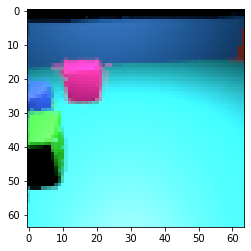

(1, 64, 64, 3)


In [275]:
#Reading full RGB image
rgb_image = imageio.imread(f'images/rgb/rgb_{full_frame_index + 1}.png')

plt.imshow(rgb_image[:,:,0:3], vmin=0, vmax=255)
plt.show()

#Goal : rgb_in & rgb_gt : [B, 1, 64, 64, 3]

print(rgb_image[None,:,:,0:3].shape)

sample_frames['rgb_in'].append(rgb_image[None,:,:,0:3])
sample_frames['rgb_gt'].append(rgb_image[None,:,:,0:3])

In [276]:
format(full_frame_index-3, '04')

'0006'

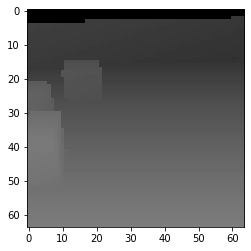

(1, 64, 64)


In [277]:
#Reading depth map
depth_image = imageio.imread("depth_map/aov_image_" + format(full_frame_index-2, '04') + ".png")
plt.imshow(depth_image[:,:,0], cmap = 'gray', vmin=0, vmax=255)
plt.show()


#Goal : depth_gt [B, 1, 64, 64]

print(depth_image[None,:,:,0].shape)

sample_frames['depth_gt'].append(depth_image[None,:,:,0])

In [278]:
current_object_on_index_i = 0
object_latent_variable = np.array(data['contentList'][current_i]['foregroundObjects'][current_object_on_index_i]['position'] + [0.0, 1.0])

object_latent_variable.shape

(5,)

In [279]:
foreground_len = len(data['contentList'][current_i]['foregroundObjects'])
background_len = len(data['contentList'][current_i]['backgroundObjects'])

In [280]:
foreground_mask_instances = []
foreground_latent_instances = []
for i in range(foreground_len):
    single_mask_instance = imageio.imread(f'images/instances/Instance_{full_frame_index+2+i}.png')
    restructured_single_mask_instance = (single_mask_instance[:,:,:] > 0)*255
    foreground_mask_instances.append(restructured_single_mask_instance)
    
    
    orientation = 0.0
    scale = 0.0
    
    object_latent_variable = np.array(data['contentList'][current_i]['foregroundObjects'][i]['position'] + [orientation, scale])
    foreground_latent_instances.append(object_latent_variable)

(3, 1, 64, 64)
(3, 1, 5)


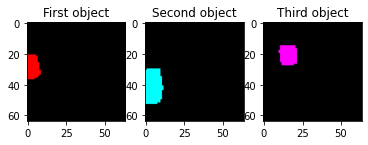

In [281]:
## Foreground Objects
fig, axs = plt.subplots(1, 3)

axs[0].imshow(foreground_mask_instances[0], cmap = 'gray', vmin=0, vmax=255)
axs[0].set_title('First object')
axs[1].imshow(foreground_mask_instances[1], cmap = 'gray', vmin=0, vmax=255)
axs[1].set_title('Second object')
axs[2].imshow(foreground_mask_instances[2], cmap = 'gray', vmin=0, vmax=255)
axs[2].set_title('Third object')


#Goal 'fore_msk_gt' [B, N, 1, 64, 64]

print(np.array(foreground_mask_instances)[:,None,:,:,0].shape)

sample_frames['fore_msk_gt'].append(np.array(foreground_mask_instances)[:,None,:,:,0])

#Goal 'fore_z_extr_gt' [B,N,1,5]

print(np.array(np.array(foreground_latent_instances))[:,None,:].shape)

sample_frames['fore_z_extr_gt'].append(np.array(np.array(foreground_latent_instances))[:,None,:])

In [282]:
background_mask_instances = []
background_latent_instances = []

for i in range(background_len):
    single_mask_instance = imageio.imread(f'images/instances/Instance_{full_frame_index+2+foreground_len + i}.png')
    restructured_single_mask_instance = (single_mask_instance[:,:,:] > 0)*255
    background_mask_instances.append(restructured_single_mask_instance)
    
    orientation = 0.0
    scale = 0.0
    
    object_latent_variable = np.array(data['contentList'][current_i]['backgroundObjects'][i]['position'] + [orientation, scale])
    background_latent_instances.append(object_latent_variable)
    

(5, 1, 64, 64)
(5, 1, 5)


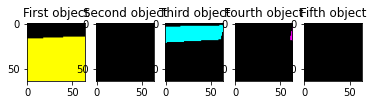

In [283]:
## Background Objects
fig, axs = plt.subplots(1, 5)


axs[0].imshow(background_mask_instances[0], cmap = 'gray', vmin=0, vmax=255)
axs[0].set_title('First object')
axs[1].imshow(background_mask_instances[1], cmap = 'gray', vmin=0, vmax=255)
axs[1].set_title('Second object')
axs[2].imshow(background_mask_instances[2], cmap = 'gray', vmin=0, vmax=255)
axs[2].set_title('Third object')
axs[3].imshow(background_mask_instances[3], cmap = 'gray', vmin=0, vmax=255)
axs[3].set_title('Fourth object')
axs[4].imshow(background_mask_instances[4], cmap = 'gray', vmin=0, vmax=255)
axs[4].set_title('Fifth object')


#Goal 'back_msk_gt' [B, N, 1, 64, 64]

print(np.array(background_mask_instances)[:,None,:,:,0].shape)

sample_frames['back_msk_gt'].append(np.array(background_mask_instances)[:,None,:,:,0])

#Goal 'back_z_extr_gt' [B,N,1,5]

print(np.array(background_latent_instances)[:,None,:].shape)

sample_frames['back_z_extr_gt'].append(np.array(background_latent_instances)[:,None,:])


In [284]:
print(np.array(foreground_mask_instances).shape)

(3, 64, 64, 4)


In [285]:
sample_frames.keys()

dict_keys(['rgb_in', 'rgb_gt', 'depth_gt', 'fore_msk_gt', 'fore_z_extr_gt', 'back_msk_gt', 'back_z_extr_gt'])

## Finally , go through all samples (restart kernel from here)

In [1]:
import json
import numpy as np

from scipy import misc
import glob
import imageio

In [2]:
def get_absolute_depth_image(image,near = 0.8, far = 15):
    k1 = (far + near) / (far - near)
    k2 = (- 2.0 * far * near) / (far - near)

    divisor = np.max(image[:,:,0]) if np.max(image[:,:,0]) != 0 else 127.0 
    res = k2 / ((image[:,:,0] / divisor) - k1)  


    return res

In [3]:
!ls full_12k_samples_dataset_3_objects

Dataset294cada5-594a-427e-bd62-4bfea69756ba  depth_map	instances  logs  rgb


In [8]:
sample_frames = {'rgb_in' : [], 'rgb_gt' : [], 'depth_gt' : [], 'fore_msk_gt' : [], 'fore_z_extr_gt' : [], 'back_msk_gt' : [], 'back_z_extr_gt' : []}

path = 'full_12k_samples_dataset_3_objects'
with open(f'{path}/logs/objects_relative_to_cam.json') as f:
  data = json.load(f)

frame_count = len(data['contentList'])

for current_i_frame in range(1,frame_count-1):
    full_frame_index = data['contentList'][current_i_frame]['index']

    foreground_len = len(data['contentList'][current_i_frame]['foregroundObjects'])
    background_len = len(data['contentList'][current_i_frame]['backgroundObjects'])
    
    #Reading full RGB image
    rgb_image = imageio.imread(f'{path}/rgb/rgb_{full_frame_index + 1}.png')
    #Goal : rgb_in & rgb_gt : [B, 1, 64, 64, 3]
    #print(rgb_image[None,:,:,0:3].shape)

    sample_frames['rgb_in'].append(rgb_image[None,:,:,0:3])
    sample_frames['rgb_gt'].append(rgb_image[None,:,:,0:3])
    

    #Reading depth map
    depth_image = imageio.imread(f'{path}/depth_map/aov_image_' + format(full_frame_index-2, '04') + ".png")
    absolute_depth_image = get_absolute_depth_image(depth_image).astype('float32')
    
    #Goal : depth_gt [B, 1, 64, 64]

    sample_frames['depth_gt'].append(absolute_depth_image[None,:,:,None])
    
    foreground_mask_instances = []
    foreground_latent_instances = []
    for current_object in range(foreground_len):
        single_mask_instance = imageio.imread(f'{path}/instances/Instance_{full_frame_index+2+current_object}.png')
        restructured_single_mask_instance = (single_mask_instance[:,:,:] > 0).astype('bool')
        foreground_mask_instances.append(restructured_single_mask_instance)


        orientation = data['contentList'][current_i_frame]['foregroundObjects'][current_object]['orientation']
        scale = data['contentList'][current_i_frame]['foregroundObjects'][current_object]['scale']

        object_latent_variable = np.array(data['contentList'][current_i_frame]['foregroundObjects'][current_object]['position'] + [orientation, scale])
        foreground_latent_instances.append(object_latent_variable)
    
    #Goal 'fore_msk_gt' [B, N, 1, 64, 64]

    sample_frames['fore_msk_gt'].append(np.array(foreground_mask_instances)[:,None,:,:,0])
    
    #Goal 'fore_z_extr_gt' [B,N,1,5]

    sample_frames['fore_z_extr_gt'].append(np.array(foreground_latent_instances)[:,None,:])
    
    
    background_mask_instances = []
    background_latent_instances = []

    for current_object in range(background_len):
        single_mask_instance = imageio.imread(f'{path}/instances/Instance_{full_frame_index+2+foreground_len + current_object}.png')
        restructured_single_mask_instance = (single_mask_instance[:,:,:] > 0).astype('bool')
        background_mask_instances.append(restructured_single_mask_instance)

        orientation = data['contentList'][current_i_frame]['backgroundObjects'][current_object]['orientation']
        scale = data['contentList'][current_i_frame]['backgroundObjects'][current_object]['scale']

        object_latent_variable = np.array(data['contentList'][current_i_frame]['backgroundObjects'][current_object]['position'] + [orientation, scale])
        background_latent_instances.append(object_latent_variable)
    
    
    #Goal 'back_msk_gt' [B, N, 1, 64, 64]

    sample_frames['back_msk_gt'].append(np.array(background_mask_instances)[:,None,:,:,0])

    #Goal 'back_z_extr_gt' [B,N,1,5]

    sample_frames['back_z_extr_gt'].append(np.array(background_latent_instances)[:,None,:])
    
    if(current_i_frame % 100 == 0):
        print(f'{current_i_frame}/12000, {current_i_frame/12000}%')

100/12000, 0.008333333333333333%
200/12000, 0.016666666666666666%
300/12000, 0.025%
400/12000, 0.03333333333333333%
500/12000, 0.041666666666666664%
600/12000, 0.05%
700/12000, 0.058333333333333334%
800/12000, 0.06666666666666667%
900/12000, 0.075%
1000/12000, 0.08333333333333333%
1100/12000, 0.09166666666666666%
1200/12000, 0.1%
1300/12000, 0.10833333333333334%
1400/12000, 0.11666666666666667%
1500/12000, 0.125%
1600/12000, 0.13333333333333333%
1700/12000, 0.14166666666666666%
1800/12000, 0.15%
1900/12000, 0.15833333333333333%
2000/12000, 0.16666666666666666%
2100/12000, 0.175%
2200/12000, 0.18333333333333332%
2300/12000, 0.19166666666666668%
2400/12000, 0.2%
2500/12000, 0.20833333333333334%
2600/12000, 0.21666666666666667%
2700/12000, 0.225%
2800/12000, 0.23333333333333334%
2900/12000, 0.24166666666666667%
3000/12000, 0.25%
3100/12000, 0.25833333333333336%
3200/12000, 0.26666666666666666%
3300/12000, 0.275%
3400/12000, 0.2833333333333333%
3500/12000, 0.2916666666666667%
3600/12000, 0

In [5]:
    #Goal : rgb_in & rgb_gt : [B, 1, 64, 64, 3]
print(np.array(sample_frames['rgb_in']).shape)
    #Goal : depth_gt [B, 1, 64, 64]
print(np.array(sample_frames['depth_gt']).shape)
    #Goal 'fore_msk_gt' [B, N, 1, 64, 64]
print(np.array(sample_frames['fore_msk_gt']).shape)
    #Goal 'fore_z_extr_gt' [B,N,1,5]
print(np.array(sample_frames['fore_z_extr_gt']).shape)
    #Goal 'back_msk_gt' [B, N, 1, 64, 64]
print(np.array(sample_frames['back_msk_gt']).shape)
    #Goal 'back_z_extr_gt' [B,N,1,5]
print(np.array(sample_frames['back_z_extr_gt']).shape)

(14443, 1, 64, 64, 3)
(14443, 1, 64, 64, 1)
(14443, 3, 1, 64, 64)
(14443, 3, 1, 5)
(14443, 5, 1, 64, 64)
(14443, 5, 1, 5)


In [7]:
sample_frames['depth_gt'][0].dtype

dtype('float64')

In [23]:
## Saving them
split_ranges =  {'train' : (0,9000),'val' : (9000,10000), 'test' : (10000,12500)} 

for key,value in sample_frames.items():
    for split_type, split_range  in split_ranges.items():
        with open(f'{key}_{split_type}.npy', 'wb') as f:
            save_value = np.array(value[split_range[0]:split_range[1]])
            print(save_value.shape)
            np.save(key + '_' + split_type, save_value)

(9000, 1, 64, 64, 3)
(1000, 1, 64, 64, 3)
(2500, 1, 64, 64, 3)
(9000, 1, 64, 64, 3)
(1000, 1, 64, 64, 3)
(2500, 1, 64, 64, 3)
(9000, 1, 64, 64, 1)
(1000, 1, 64, 64, 1)
(2500, 1, 64, 64, 1)
(9000, 3, 1, 64, 64)
(1000, 3, 1, 64, 64)
(2500, 3, 1, 64, 64)
(9000, 3, 1, 5)
(1000, 3, 1, 5)
(2500, 3, 1, 5)
(9000, 5, 1, 64, 64)
(1000, 5, 1, 64, 64)
(2500, 5, 1, 64, 64)
(9000, 5, 1, 5)
(1000, 5, 1, 5)
(2500, 5, 1, 5)


In [24]:
!ls

back_msk_gt_test.npy	  fore_z_extr_gt_train.npy
back_msk_gt_train.npy	  fore_z_extr_gt_val.npy
back_msk_gt_val.npy	  full_12k_samples_dataset_3_objects
back_z_extr_gt_test.npy   ObjectRoom
back_z_extr_gt_train.npy  README.md
back_z_extr_gt_val.npy	  rgb_gt_test.npy
depth_gt_test.npy	  rgb_gt_train.npy
depth_gt_train.npy	  rgb_gt_val.npy
depth_gt_val.npy	  rgb_in_test.npy
fore_msk_gt_test.npy	  rgb_in_train.npy
fore_msk_gt_train.npy	  rgb_in_val.npy
fore_msk_gt_val.npy	  script.py
fore_z_extr_gt_test.npy   Unity_recorder_preprocessing.ipynb
